In [191]:
%matplotlib inline
from __future__ import print_function
from simdna import synthetic as sn
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
import tutorial_utils
from tutorial_utils import viz_sequence_highlight_motifs
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence
import modisco_tutorial

# Overview

Describe the simulation (number per type of sequence, the three tasks, the different motifs, ENCODE images of the motifs, and also the GC content)

# Loading the raw data

Load in the testing set of our model for analysis

In [2]:
raw_data = sn.read_simdata_file("sequences.simdata.gz", ids_to_load=fp.read_rows_into_arr("splits/test.txt.gz"))

Let's inspect the contents of the raw_data object

First, we can access the raw underlying sequence

In [3]:
raw_data.sequences[:5]

['CTTGTATTGAGTTAGAAACCGCCACGGCACTGCTATGTATGACATTCTAACTAAGTGAGTTATGCGTTGGGTCCTTTATGTGGCATTATCTGGTAATACTTAATTGATGTACTATTTCCTCGACAAAACAGGTGGTGTGGGTGTACCGGTCACCGATAAGGGGGAACTCACCAGATGGTAGTTAACCTATAGAGTCCTGA',
 'TGACAATGGACCCGGTCCGGGTTAGGTACTGATTAGGAACGACCCAGGCCGAGCGACTTATCCCGTTAGATGACGGAATCGTTGTTAGCGGAAAAGAGATAAGAACTTCCCAATTTATACAGATAAGCACACAATGTTTAACGTTCCCGTCTGAGTACTCCTGAATGGGAAGGATATTCTATACTAAGGGATTAGTCGTG',
 'CGTTTGAAAGGAGACCAGGTGGTCCAACCACAGTAGCAGAATATTATGCGGTTGTCGATAGAGCTTTGCTAACAGATGTTTACAGTTATCCTGAAATCGTTTGGACAAACTGTCTTCGTGCGTAATTGCACTGTTATGGCCCAGTACAGGGGATCAGATGGTCATGGCAAAAGGCGTGCCAACGCTCGAACTGGAGTCTT',
 'TATGACGACTGCGTATAGTAGACAGATGGTGGACAATTCCCCGTTACATAAAGGGGTACAGATGGTAAGTCCACAAACCGTAACGGCAACAGATGTTTTGAGGTACAAATATAAGGTCCTGATAAGGAGCCGAGAGCTGACGCGTGCCCAATGAGTACATACGTGATACGAATGCGTGCGCCCGGAGTATGTCAAACCGT',
 'CAGTATCTACTGAAAGGAGAATGCACTTGCCGCAATTAACATCCTCTGATTGCACTTGAGTATTTAACAATATATTATGAGCAAGACGCCGGCCTTGTAAAAGACCAAATATAAGGACAATCTAGGGGCGCGTGACCAAGACTGCATCATATCTTCCAAATTTAGTAGTACGCCGTGG

...As well as the labels

In [4]:
print(raw_data.labels[:5])

[[1 1 1]
 [0 1 0]
 [0 0 1]
 [1 1 1]
 [0 0 0]]


As well as the actual contents of the motif objects that were embedded in the original simulation. Can you verify the relationship between the labels and the embeddings?

In [5]:
print("\n".join(", ".join(str(embedding) for embedding in embeddings_one_seq)
                     for embeddings_one_seq in raw_data.embeddings[:5]))

pos-151_GATA_disc1-ACCGATAAGG, pos-123_TAL1_known1-CAAAACAGGTGGTGTG, pos-166_TAL1_known1-CTCACCAGATGGTAGT
pos-94_GATA_disc1-AGAGATAAGA, pos-118_GATA_disc1-ACAGATAAGC, pos-27_GATA_disc1-ACTGATTAGG
pos-149_TAL1_known1-GGGATCAGATGGTCAT, pos-67_TAL1_known1-GCTAACAGATGTTTAC, pos-10_TAL1_known1-GAGACCAGGTGGTCCA
pos-161_GATA_disc1-CGTGATACGA, pos-117_GATA_disc1-CCTGATAAGG, pos-84_TAL1_known1-GGCAACAGATGTTTTG, pos-53_TAL1_known1-GGGTACAGATGGTAAG, pos-17_TAL1_known1-GTAGACAGATGGTGGA



We are going to have to one-hot encode the data, so let's do that

In [6]:
one_hot_data = avutils.util.one_hot_encode_sequences(raw_data.sequences)

Let's inspect the shape of the one-hot encoded data

In [18]:
one_hot_data.shape

(800, 1, 4, 200)

The one-hot encoded data has dimensions of sample x channel x row (acgt) x column (position along sequence). The channel axis always has length 1 in the input layer, but will have a larger length after the convolutional layers (this is the dimension that will store the different convolutional channels).

# PART 1: Importance scores on individual positions

## Make a DeepLIFT model from a Keras model

Let's now set up a DeepLIFT model. In this tutorial, we will start with a keras model and use the deeplift autoconversion functions to create a DeepLIFT model. Note that it is not necessary to have a keras model; if you have a model trained with a different package, you can write your own conversion scripts to put it in the DeepLIFT format - information on how to do so is documented on the DeepLIFT repo https://github.com/kundajelab/deeplift#under-the-hood. For now, we will stick to the autoconversion.

We will start with loading a keras model. We're going to load a Keras graph model (version 0.3.2). When we load the model, we need to specify the weights and the configuration (the weights are stored in the .h5 format and the configuration is stored in the .yaml format). We should also specify that the weights of the first conv layer be normalized such that the mean of the weights at any given position sum to 0; this deconvolves the weights and the biases and makes the resulting filters more interpretable. The normalization is output-preserving, so the outputs of the net are identical in both cases. (A bonus problem is to investigate what happens when this normalization is removed).

In [256]:
keras_model_weights = "model_files/record_1_model_9vvXe_modelWeights.h5"
keras_model_yaml = "model_files/record_1_model_9vvXe_modelYaml.yaml"

keras_model = kc.load_keras_model(weights=keras_model_weights,
                                  yaml=keras_model_yaml,
                                  normalise_conv_for_one_hot_encoded_input=True,
                                  name_of_conv_layer_to_normalise="conv1")

We can inspect the input layers of the keras model as follows:

In [257]:
keras_model.inputs

{'sequence': <keras.layers.core.Layer at 0x7f2243060110>}

We can inspect all the intermediate nodes of the model as follows:

In [258]:
keras_model.nodes

OrderedDict([('conv1',
              <keras.layers.convolutional.Convolution2D at 0x7f214b9debd0>),
             ('conv1_act', <keras.layers.core.Activation at 0x7f22431fc790>),
             ('conv2',
              <keras.layers.convolutional.Convolution2D at 0x7f214c87a950>),
             ('conv2_act', <keras.layers.core.Activation at 0x7f214c55a650>),
             ('avg_pool',
              <keras.layers.convolutional.AveragePooling2D at 0x7f2149d97c50>),
             ('flatten', <keras.layers.core.Flatten at 0x7f22434766d0>),
             ('dense1', <keras.layers.core.Dense at 0x7f214abd6590>),
             ('dense1_act', <keras.layers.core.Activation at 0x7f22431fc210>),
             ('dense1_dropout', <keras.layers.core.Dropout at 0x7f2250e5e690>),
             ('output_preact', <keras.layers.core.Dense at 0x7f2250e5e150>),
             ('output_act', <keras.layers.core.Activation at 0x7f2250e5e290>)])

We will now convert the Keras model to the DeepLIFT format using the provided autoconverion functions. We will set the nonlinear multiplier mode to DeepLIFT and the Dense layer multiplier mode to linear (other variants are explored later in the notebook).

In [259]:
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
deeplift_model = kc.convert_graph_model(model=keras_model,
                                        nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT,
                                        dense_mxts_mode=DenseMxtsMode.Linear)

Let's do a sanity check that the conversion happened correctly. We can view the blobs in the converted model as follows (a blob is the equivalent of a layer - we named them 'blobs' to avoid any implication of sequentiality):

In [260]:
deeplift_model.get_name_to_blob()

OrderedDict([('sequence', <deeplift.blobs.core.Input at 0x7f214a242ed0>),
             ('conv1', <deeplift.blobs.convolution.Conv2D at 0x7f2148edaa90>),
             ('conv1_act',
              <deeplift.blobs.activations.ReLU at 0x7f214b3dc490>),
             ('conv2', <deeplift.blobs.convolution.Conv2D at 0x7f224374f1d0>),
             ('conv2_act',
              <deeplift.blobs.activations.ReLU at 0x7f2148eda8d0>),
             ('avg_pool',
              <deeplift.blobs.convolution.AvgPool2D at 0x7f2148edae50>),
             ('flatten',
              <deeplift.blobs.convolution.Flatten at 0x7f22426a9c50>),
             ('dense1', <deeplift.blobs.core.Dense at 0x7f2241b6f150>),
             ('dense1_act',
              <deeplift.blobs.activations.ReLU at 0x7f22426a96d0>),
             ('dense1_dropout', <deeplift.blobs.core.NoOp at 0x7f22426a9450>),
             ('output_preact', <deeplift.blobs.core.Dense at 0x7f22426a9a10>),
             ('output_act',
              <deeplift.blobs

You can see that most of the keras layers have an equivalent DeepLIFT blob. One exception is the Dropout layer, which maps to a blob object of type "NoOp" ("No Operation"). For those of you familiar with dropout: a dropout layer affects the behaviour of the net while it is training, but does nothing when it's time to make predictions. As deeplift is only applied to models after they are trained, the dropout layer maps to a "NoOp" blob which is the identity function.

## Sanity check the conversion

As a sanity check to make sure the conversion happened correctly, let's define a function to make predictions with this converted deeplift model and verify that it gives the same outputs as the original keras model. We can create a function using get_prediction_fucntion, as shown:

In [261]:
#output_layer_names is a list of the layer that you are getting the outputs of
#input_layer_names is a list of the layers that you are using as inputs to the outputs
deeplift_prediction_function = deeplift_model.get_prediction_function(
    input_layer_names=['sequence'],
    output_layer_name='output_act'
)
#batch_size refers to a batch size for the GPU; predictions are made in batches on the GPU for efficiency
#we retrieve the output at index [0] because we got predictions for just one layer, so the outputs we want
#are at index 0 in the resulting array
deeplift_model_predictions = deeplift_prediction_function([one_hot_data], batch_size=20)

Let's obtain the corresponding predictions from the original keras model

In [262]:
keras_model_predictions = keras_model.predict({'sequence':one_hot_data}, batch_size=20)['output']

Now print out the maximum difference between the two predictions. This should be within numerical accuracy.

In [263]:
print(np.max(np.abs(deeplift_model_predictions-keras_model_predictions)))

0.0


## Get importance scores from the model

This is how we get the function that actually produces importance scores. find_scores_layer_name refers to the layer that we want to find the importance scores for - in this case, the input sequence. pre_activation_target_layer_name refers to the layer that we are computing the contributions to - this should refer to the linear layer prior to the final nonlinearity. We compute the contributions with respect to the linear layer prior to the final sigmoid nonlinearity because, if we computed otherwise the sum of the contributions would be capped at 1 regardless of how confident the example was.

In [239]:
deeplift_scoring_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_name="sequence",
                            pre_activation_target_layer_name="output_preact")

We can now compute the scores on all the sequences for all three tasks. The first step is to prepare the reference. We will compute the scores with respect to a reference of 40% GC content, which matches the simulation.

In [240]:
GC_array = np.array([0.3, 0.2, 0.2, 0.3]) #positions are A,C,G,T
#[None,None,:,None] refers to the broadcast pattern; one_hot_data
#has dimensions: sample x channel x rows x columns
#the rows are acgt, the columns refer to the position
#along the sequence, and the channel is a dummy axis for the first input layer.
#Thus, we will broadcast over sample, channel and columns.
reference_40GC = np.ones_like(one_hot_data)*GC_array[None,None,:,None]

Let's inspect the reference. Here we look at the first 10 positions of the first two sequences.

In [241]:
print(reference_40GC[0:2, :, :, 0:10])

[[[[ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]]]


 [[[ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]
   [ 0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3  0.3]]]]


In [242]:
task_to_deeplift_scores_unsummed = OrderedDict()
for task_idx in [0,1,2]:
    task_to_deeplift_scores_unsummed[task] = np.array(deeplift_scoring_func(
                                                task_idx=task_idx,
                                                input_data_list=[one_hot_data],
                                                input_references_list=[reference_40GC],
                                                batch_size=20,
                                                #if you pass an integer for progress_update, you will get
                                                #a message printed every time that number of items is processed
                                                progress_update=None))

Aside: it would also have worked to provide GC_array[None,None,:,None] as the reference, because the broadcast would have been done automatically so that the reference had the same dimensions as the input. The advantage of having a reference with the same dimensions as the input is that it's possible to have a different reference for each individual sample in the input.

Let's inspect the resulting scores array for a particular task

In [243]:
print("Shape: ",str(task_to_deeplift_scores_unsummed[0].shape))
print(task_to_deeplift_scores_unsummed[0][0][0][:,0:3])

Shape:  (800, 1, 4, 200)
[[ -1.52351728e-04  -7.07035406e-06   2.62477610e-04]
 [ -7.70138227e-04   9.57420925e-05   5.35698382e-05]
 [ -1.50667474e-04  -3.19191713e-05   9.90400586e-05]
 [  8.95511112e-05   2.06882862e-04   1.14658242e-03]]


We see that the importance scores have the same dimensions as the input. Question: why are scores on all four positions of A,C,G,T nonzero, even though the input is one-hot-encoded (meaning at most one of those positions can be nonzero in the input)? (Hint: what is the reference?)

Let's sum over acgt at each position (so that we get a sense of the total contribution of each position), and let's also get rid of the channel axis as it's a dummy axis:

In [244]:
task_to_deeplift_scores = OrderedDict()
for task in task_to_deeplift_scores_unsummed:
    task_to_deeplift_scores[task] = np.squeeze(np.sum(task_to_deeplift_scores_unsummed[task],axis=2),axis=1)

## Visualize scores on a sequence

We can now visualize the deeplift scores of an individual sequence. In the visualization, the blue boxes indicate the true locations of embedded GATA motifs, and the green boxes indicate true locations of embedded TAL1 motifs.

Visualizing task 0


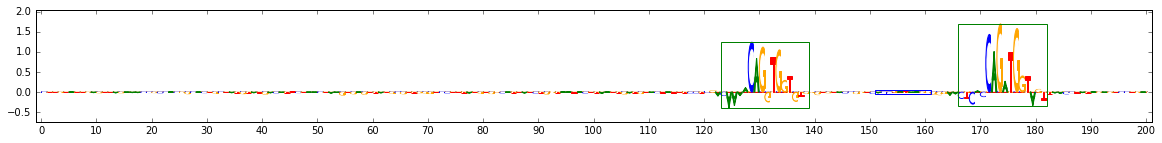

In [245]:
idx=0
for task in task_to_deeplift_scores:
    print("Visualizing task",task)
    viz_sequence_highlight_motifs(task_to_deeplift_scores[task][idx], one_hot_data[idx], raw_data.embeddings[idx])

## A different variant of DeepLIFT

The highlighting of the TAL motifs in the example above for task 0 may be dissatisfing. It turns out that the behaviour of the algorithm can be improved by setting dense_mxts_mode to DenseMxtsMode.Counterbalance. We will create a model for the counterbalance scores and evaluate its performance on the sequence above. To make things easier this time, we shall define the following convenience functions:

We now need to get the scores from this model. To make things easier this time, we shall define the following convenience functions:

In [246]:
def get_scores_given_scoring_func(scoring_func, one_hot_data, reference, task_idx):
    return np.squeeze(
            np.sum(
                np.array(scoring_func(
                    task_idx=task_idx,
                    input_data_list=[one_hot_data],
                    input_references_list=[reference],
                    batch_size=20,
                    progress_update=None)),
                axis=2),
            axis=1)

def viz_scores_for_tasks(seq_idx, task_to_scores, one_hot_data, embeddings):
    print("Visualizing index",seq_idx)
    for task_idx in task_to_scores:
        print("Task",task_idx)
        viz_sequence_highlight_motifs(
            task_to_scores[task_idx][seq_idx],
            one_hot_data[seq_idx],
            embeddings[idx])

Let's obtain and visualize the scores of the counterbalance model on the same sequence. Fill in the cell below where indicated:

Visualizing index 0
Task 0


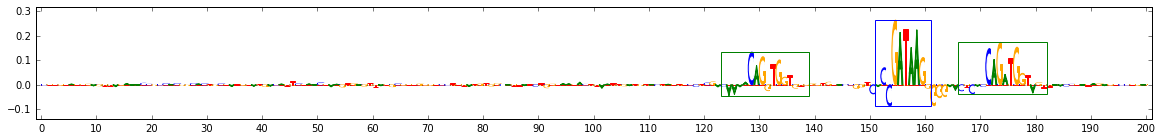

Task 1


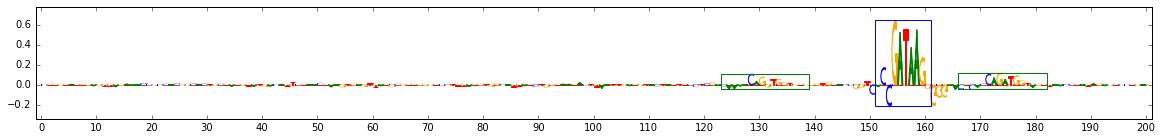

Task 2


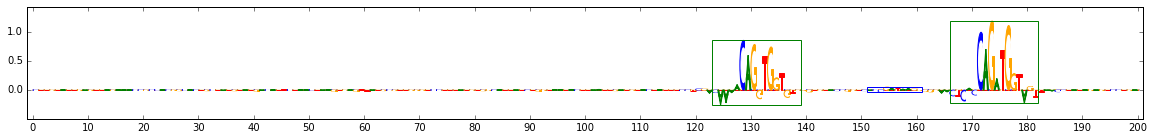

In [266]:
#counterbalance_deeplift_model = #fill me in!
#hint: use kc.convert_graph_model, but with NonlinearMxtsMode.DeepLIFT and DenseMxtsMode.Counterbalance

#counterbalance_scoring_func = #fill me in!

task_to_counterbalance_deeplift_scores = OrderedDict()
for task_idx in [0,1,2]:
    task_to_counterbalance_deeplift_scores[task_idx] = get_scores_given_scoring_func(
                        scoring_func=counterbalance_scoring_func,
                        one_hot_data=one_hot_data,
                        reference=reference_40GC,
                        task_idx=task_idx)
    
viz_scores_for_tasks(seq_idx=0,
                     task_to_scores=task_to_counterbalance_deeplift_scores,
                     one_hot_data=one_hot_data,
                     embeddings=raw_data.embeddings)

####
#Answers here! Don't read until you try it yourself!
###
#counterbalance_deeplift_model =  kc.convert_graph_model(model=keras_model,
#                                        nonlinear_mxts_mode=NonlinearMxtsMode.DeepLIFT,
#                                        dense_mxts_mode=DenseMxtsMode.Counterbalance)
#counterbalance_scoring_func = counterbalance_deeplift_model.get_target_contribs_func(
#                                find_scores_layer_name="sequence",
#                                pre_activation_target_layer_name="output_preact")

What do you think of the relative merits of the two methods?

## Comparing various methods

We can go through and define a whole host of different scoring models. Let's compile a bunch of models and their scores:

In [267]:
#have them play around with different scoring emthods. Direct them to specific examples to look at.

## Importance of the reference

In [268]:
#show auPRC degrading with different references

# Part 2: Motif discovery

We start by getting the positive set for task 0.

In [269]:
task_idx = 0
model_to_use = counterbalance_deeplift_model
one_hot_data_positives = np.array([one_hot for one_hot,labels in
                            zip(one_hot_data, raw_data.labels) if labels[task]==1])
modisco_reference = np.array([0.3, 0.2, 0.2, 0.3])[None,None,:,None]

## Visualize the top-scoring filters

Now, let's try visualizing the top convolutional filters. We start by computing the scores on the first convolutional layer.

In [270]:
conv_layer_contribs_func = model_to_use.get_target_contribs_func(
                            find_scores_layer_name='conv1',
                            pre_activation_target_layer_name="output_preact")
conv_layer_contribs = np.array(conv_layer_contribs_func(
                                task_idx=task_idx,
                                input_data_list=[one_hot_data_positives],
                                input_references_list=[modisco_reference],
                                batch_size=200, progress_update=None))

Let's now histogram the scores across all the channels

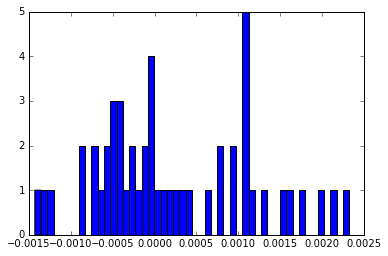

In [271]:
per_channel_scores = np.mean(np.squeeze(conv_layer_contribs), axis=(-1,0))
import matplotlib.pyplot as plt
#histogram filter importance scores
hist = plt.hist(per_channel_scores, bins=50)
plt.show()

Let's visualize individual convolutional filters. We can obtain the weights of the filters and biases as shown below

In [272]:
#get the actual weights and biases
conv_weights, conv_biases = model_to_use.get_name_to_blob()['conv1'].W,\
                                    model_to_use.get_name_to_blob()['conv1'].b
#The shape of the weights is:
#number of filters x number of input channels x kernel height (tgca) x filter length
print("conv_weights shape",conv_weights.shape)
#There is one bias per filter.
print("conv_biases shape",conv_biases.shape)

conv_weights shape (50, 1, 4, 11)
conv_biases shape (50,)


Note that convolutions scan the reversed sequence (if they scanned the forward sequence, they would be called cross-correlation). Thus, if there are patterns on the convolution filters, they lie on the reverse complement strand. Normally this doesn't matter as the reverse-complemented pattern occurs as often as the forward-complemented pattern, but because this is simulated data, we did not reverse-complement the patterns for ease of interpretabiility. We will thus reverse complement the weights along the last two dimensions (which see the sequence).

In [273]:
conv_weights = conv_weights[:,:,::-1,::-1]

Now we are ready to visualize the weights.

importance: 0.0023265 bias: -1.21735


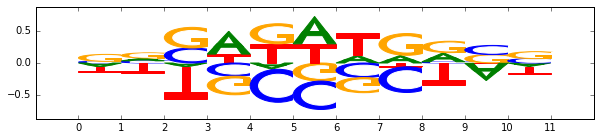

importance: 0.00214712 bias: -2.95436


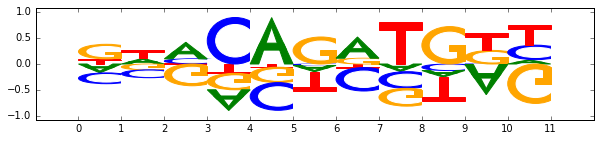

importance: 0.00196613 bias: -0.876541


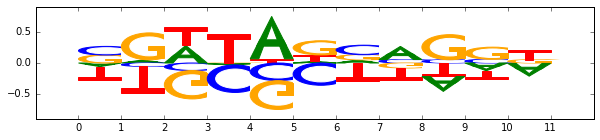

importance: 0.00177703 bias: -0.657478


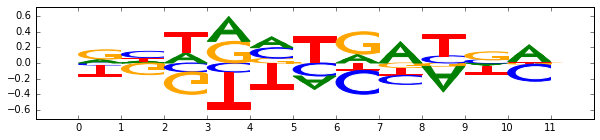

importance: 0.00162526 bias: -0.576213


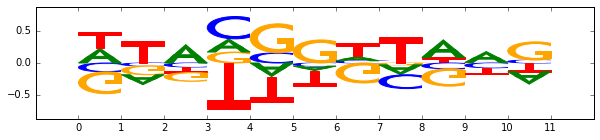

In [274]:
#sort channels in descending order of importance
channels_sorted_by_importance = sorted(
    zip(conv_weights, conv_biases, per_channel_scores),
    key=lambda x: -x[2])

#plot the weights of the top channels
for i in range(0,5):
    this_filter_bias = channels_sorted_by_importance[i][1]
    this_filter_weights = channels_sorted_by_importance[i][0][0]
    this_filter_importance = channels_sorted_by_importance[i][2]
    #normalize the weights so that each position effectively 
    print("importance: "+str(this_filter_importance)+" bias: "+str(this_filter_bias))
    viz_sequence.plot_weights(this_filter_weights, figsize=(10,2))

## Consolidating the patterns

One of the patterns - CAGATG, is visible from looking at individual filters above, but the second pattern - GATA - is not so apparent. Can we extract the more consolidated pattern? This is where MoDISco comes in.

### Compute sequence-level importance

We start by computing the importance scores on the sequence

In [275]:
sequence_contribs_func = model_to_use.get_target_contribs_func(
                                    find_scores_layer_name='sequence',
                                    pre_activation_target_layer_name='output_preact')
sequence_contribs = np.array(
                        sequence_contribs_func(task_idx=task_idx,
                            input_data_list=[one_hot_data_positives],
                            input_references_list=[modisco_reference],
                            batch_size=20, progress_update=None))

Once again, let's inspect the importance scores

In [276]:
print("Shape:",sequence_contribs.shape)
print(sequence_contribs[0,:,:,0:3])

Shape: (236, 1, 4, 200)
[[[ -1.27095118e-04   2.00718205e-05   5.56804298e-05]
  [ -5.51667355e-04  -1.36268745e-05   6.19301886e-07]
  [ -1.27116262e-04   8.55827238e-05   1.26477578e-04]
  [  1.10894260e-04   2.98679719e-04   5.74760023e-04]]]


As mentioned before, because of our choice of reference, we have importance scores on all four bases at each position even though only one base is present per position in the actual one-hot encoded sequence. This can be confusion, so for ease of interpretation we will move all of the importance onto the base that is actually present at a given position.

In [277]:
sequence_contribs = np.sum(sequence_contribs,axis=-2)[:,:,None,:]*one_hot_data_positives
print("Shape: ",sequence_contribs.shape)
print(sequence_contribs[0,:,:,0:3])

Shape:  (236, 1, 4, 200)
[[[-0.          0.          0.        ]
  [-0.00069498  0.          0.        ]
  [-0.          0.          0.        ]
  [-0.          0.00039071  0.00075754]]]


### Identify high-scoring segments

Let's now identify high-scoring segments, dubbed "seqlets"

In [316]:
segment_identifier = modisco_tutorial.FixedWindowAroundPeaks(
                                        sliding_window_for_max_size=7,
                                        flank_to_expand_around_peak_size=3,
                                        exclude_peaks_within_window=7,
                                        ratio_to_top_peaks_to_include=0.3,
                                        max_segments=6)
seqlets, seqlet_indices = modisco_tutorial.get_seqlets(
                            raw_importance_contribs=sequence_contribs,
                            segment_identifier=segment_identifier,
                            rev_comp_func=modisco_tutorial.dna_rev_comp_func)

#filter out any shorter seqlets from the edges of sequences
seqlets = modisco_tutorial.filter_shorter_seqlets(seqlets)

print("Total seqlets:",len(seqlets))

Done 0 of 236
Done 100 of 236
Done 200 of 236
Total seqlets: 659


### Augment with multiplier information

Our seqlets were identified using the importance-score track, but having identified the seqlets we can now add information from any other data track. For instance, we are going to add in information about the multipliers, as this will aid with clustering. The first step is to computer the multipliers on the sequence, which we do below.

In [317]:
sequence_multipliers_func = model_to_use.get_target_multipliers_func(
                                        find_scores_layer_name='sequence',
                                        pre_activation_target_layer_name='output_preact')
sequence_multipliers = np.array(sequence_multipliers_func(task_idx=task_idx,
                                input_data_list=[one_hot_data_positives],
                                input_references_list=[modisco_reference],
                                batch_size=20, progress_update=None))

The augmentation is done below. In addition to augmenting the seqlets with the multiplier informaiton, we also augment them with the original one-hot encoded seqlets.

In [318]:
#augment tracks
for (full_data_arr,
     name,
     pseudocount) in [
       (np.squeeze(one_hot_data_positives, axis=1).astype("float"),
        "sequence",
        0.25 #pseudocount
        #pseudocounts are useful when seqlets are merged
        #into a motif (later), but we don't want to be
        #overconfident in the frequency of bases at any
        #particular position. 0.25 means that each
        #'pseudocount' at a particular position carries
        #a value of 0.25       
       ),
       (np.squeeze(sequence_multipliers, axis=1), #data
        "sequence_multipliers",
        0.0)]:
    modisco_tutorial.augment_seqlets_with_data(
        seqlets,
        full_data_arr=full_data_arr,
        key_name=name,
        pseudocount=pseudocount,
        rev_comp_func=modisco_tutorial.dna_rev_comp_func)

Let's visually explore some of the seqlets to sanity-check that the augmentation happened as expected. The seqlets are sorted in order of total importance. Let's view a couple.

Seqlet with idx 50
Track: sequence


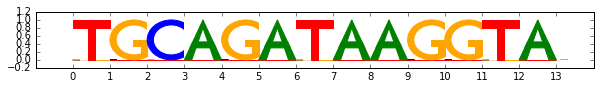

Track: core_importance_track


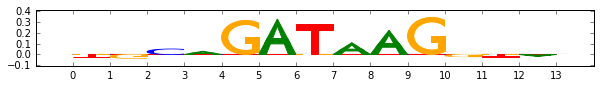

Track: sequence_multipliers


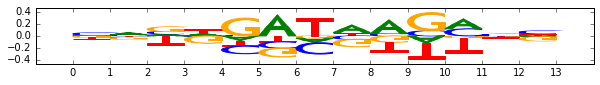

Seqlet with idx 230
Track: sequence


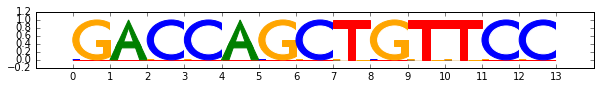

Track: core_importance_track


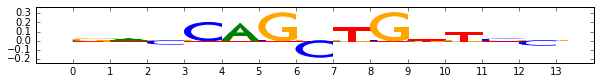

Track: sequence_multipliers


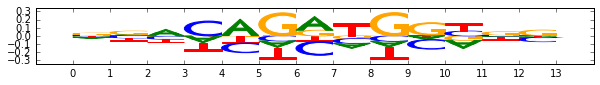

In [291]:
#visually explore some seqlets as a sanity check
track_names_to_print=["sequence", "core_importance_track", "sequence_multipliers"]
for idx in [50,230]:
    print("Seqlet with idx",idx)
    for track_name in track_names_to_print:
        print("Track:",track_name)
        viz_sequence.plot_weights(seqlets[idx].get_summed_data_track(track_name),
                                  figsize=(10,1))

Note how for the second seqlet above, the multipliers reveal that the net was hoping for an "A" in the middle of "CAGATG", even though it actually saw a "C" - in this way, the multipliers can act like an "autocomplete".

### Cluster by similarity

Now that we have the seqlets, let's compute a pairwise correlation matrix between them.

In [303]:
seqlets_corr_mat = modisco_tutorial.get_correlation_matrix(
    seqlets,
    #use the mutlipliers to do the correlation
    subtracks_to_align_on=["sequence_multipliers"],
    #in this simulated data, there are no reverse complements - however,
    #in general it is important to account for the reverse complement
    #when computing the distance matrix, so we leave this at True
    account_for_rev_comp=True,
    batch_size=20)

Num words: 659 and 659
On filters 0 to 659
Done 0
Repeating for reverse complement
On filters 0 to 659
Done 0
Seconds to compute corr mat: 1.12628483772


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 659 / 659
[t-SNE] Mean sigma: 0.109928
[t-SNE] Iteration 25: error = 0.9077724, gradient norm = 0.0182641
[t-SNE] Iteration 50: error = 0.9658601, gradient norm = 0.0188166
[t-SNE] Iteration 75: error = 0.6741716, gradient norm = 0.0095190
[t-SNE] Iteration 100: error = 0.7282559, gradient norm = 0.0123962
[t-SNE] Error after 100 iterations with early exaggeration: 0.728256
[t-SNE] Iteration 125: error = 0.6219224, gradient norm = 0.0055495
[t-SNE] Iteration 150: error = 0.6575215, gradient norm = 0.0086009
[t-SNE] Iteration 175: error = 0.6799657, gradient norm = 0.0098877
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.679966


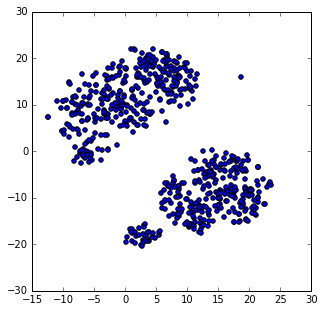

In [312]:
#find the t-sne embedding using the distance metric
np.random.seed(1234)
embedding_corr = modisco_tutorial.get_tsne_embedding_of_modisco_motifs(
                    seqlets_corr_mat, perplexity=50, verbose=2)
modisco_tutorial.scatter_plot(embedding_corr)

Let's cluster the tsne embedding by k-means

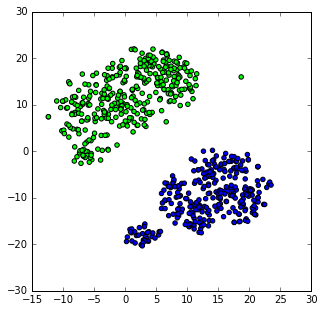

In [313]:
import sklearn.cluster
kmeans_clusters = sklearn.cluster.KMeans(n_clusters=2, n_init=10).fit_predict(embedding_corr)
modisco_tutorial.scatter_plot(embedding_corr, labels=kmeans_clusters)

### Aggregate within clusters

Within each cluster, align seqlets by their multipliers and aggregate.

In [ ]:
merged_motifs = modisco_tutorial.create_merged_modisco_motifs(
                    kmeans_clusters, seqlets,
                    subtracks_to_align_on=["sequence_multipliers"],
                    account_for_rev_comp=True)

Trim to positions that at least 50% of the seqlets align to.

In [319]:
trimming_func = modisco_tutorial.TrimArrayColumnsToNumUnderlyingObs(0.5)
merged_motifs = modisco_tutorial.adjust_modisco_motifs_using_trimming_criterion(
                    merged_motifs,
                    trimming_func=trimming_func)

Visualize the motifs.

On motif 0


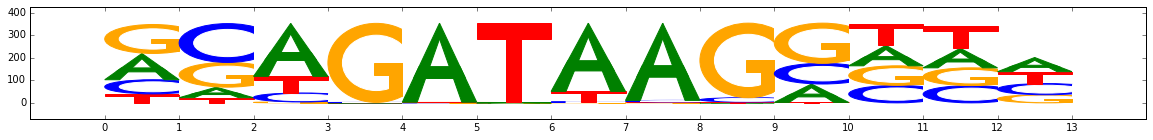

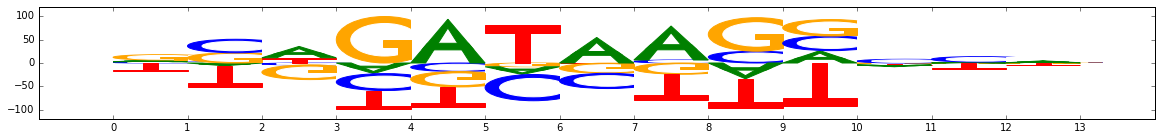

On motif 1


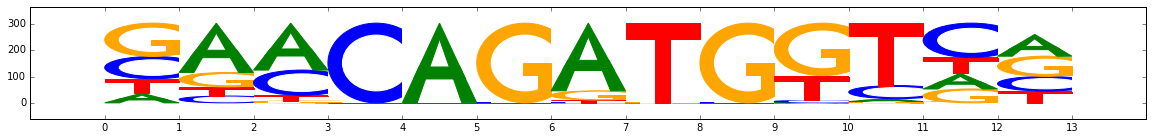

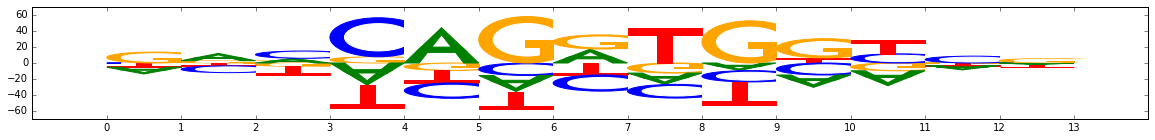

In [325]:
for motif_idx, motif in enumerate(merged_motifs.values()):
    print("On motif",motif_idx)
    for track_name in ["sequence", "sequence_multipliers"]:
        viz_sequence.plot_weights(
            motif.get_summed_data_track(track_name),
            figsize=(20,2))